In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import cmath
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
from statsmodels.tsa.api import VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from multiproc import compute_VAR
from multiproc_VAR_p_grid_search import compute_VAR_p, predict_VAR_p
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [3]:
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

# VAR(p)

In [10]:
data = lfp

In [19]:
p = 8
window = 5 # s
T_pred = 25
num_actual_windows = 50

In [20]:
VAR_results = []
stride = window
num_windows = int(np.floor((data.shape[0]-int(window/dt))/int(stride/dt)+1))
# for i in tqdm(range(num_windows)):
for i in tqdm(np.int0(np.linspace(0, num_windows - 1, num_actual_windows))):
    start_ind = i*int(stride/dt)
    start_time = i*stride
    end_ind = i*int(stride/dt) + int(window/dt)
    end_time = i*stride + window
    if end_ind + T_pred <= data.shape[0]:

        window_data = data[start_ind:end_ind]
        results = compute_VAR_p(window_data, p)
        test_data = data[end_ind - p:end_ind + T_pred]

        train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
        train_mse = ((train_prediction - train_true_vals)**2).mean()
        test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
#                 print(test_prediction.shape)
        test_mse = ((test_prediction - test_true_vals)**2).mean()
        persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

        # ADD TO DICTIONARY
        results['train_mse'] = train_mse
        results['test_mse'] = test_mse
        results['persistence_baseline'] = persistence_baseline

        # ADD TIMESTAMPS
        results['start_ind'] = start_ind
        results['end_ind'] = end_ind
        results['start_time'] = start_time
        results['end_time'] = end_time

        # ADD PARAMETERS
        results['window'] = window
        results['stride'] = stride
        results['p'] = p
        results['T_pred'] = T_pred

        VAR_results.append(results)
VAR_results = pd.DataFrame(VAR_results)

  0%|          | 0/50 [00:00<?, ?it/s]

In [66]:
A1_CIs = VAR_results.coefs.apply(lambda x: np.abs(np.linalg.eigvals(x[0]))).to_numpy()
# A1_CIs = VAR_results.coefs.apply(lambda x: np.hstack([np.abs(np.linalg.eigvals(x[i])) for i in range(len(x))])).to_numpy()

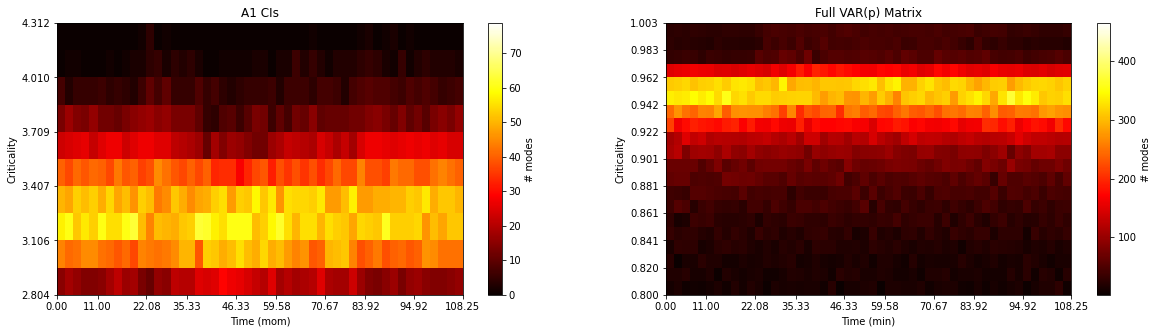

In [68]:
bin_nums = 10
bin_min = np.concatenate(A1_CIs).min()
bin_max = np.concatenate(A1_CIs).max()
bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
criticality_prob_dist = np.zeros((VAR_results.criticality_inds.shape[0], bin_nums))
for t in range(len(A1_CIs)):
    criticality_prob_dist[t] = np.histogram(A1_CIs[t], bins=bins)[0]
start_times = VAR_results.start_time/60
T_max = VAR_results.start_time.iloc[-1]/60
fig = plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
ax = plt.gca()
im = plt.pcolormesh(criticality_prob_dist.T, cmap='hot', vmin=criticality_prob_dist.min(), vmax=criticality_prob_dist.max()*1.25)
ax.set_xticks([int(i) for i in np.linspace(0, len(A1_CIs), 10)], [f"{start_times.iloc[int(i)]:.2f}" for i in np.linspace(0, len(A1_CIs)-1, 10)])
ax.set_yticks(np.arange(0, bin_nums + 1, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, bin_nums + 1, 2)]])
cb = fig.colorbar(im, ax=ax)
cb.set_label(label='# modes')
plt.xlabel("Time (mom)")
plt.ylabel("Criticality")
plt.title("A1 CIs")

bin_nums = 20
bin_min = np.concatenate(VAR_results.criticality_inds.to_numpy()).min()
bin_min = 0.8
bin_max = np.concatenate(VAR_results.criticality_inds.to_numpy()).max()
bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
criticality_prob_dist = np.zeros((VAR_results.criticality_inds.shape[0], bin_nums))
for t in range(len(A1_CIs)):
    criticality_prob_dist[t] = np.histogram(VAR_results.criticality_inds.iloc[t], bins=bins)[0]
start_times = VAR_results.start_time/60
T_max = VAR_results.start_time.iloc[-1]/60
plt.subplot(1, 2, 2)
plt.title("Full VAR(p) Matrix")
ax = plt.gca()
im = plt.pcolormesh(criticality_prob_dist.T, cmap='hot', vmin=criticality_prob_dist.min(), vmax=criticality_prob_dist.max()*1.25)
ax.set_xticks([int(i) for i in np.linspace(0, len(A1_CIs), 10)], [f"{start_times.iloc[int(i)]:.2f}" for i in np.linspace(0, len(A1_CIs)-1, 10)])
ax.set_yticks(np.arange(0, bin_nums + 1, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, bin_nums + 1, 2)]])
cb = fig.colorbar(im, ax=ax)
cb.set_label(label='# modes')
plt.xlabel("Time (min)")
plt.ylabel("Criticality")
plt.show()

In [60]:
scipy.stats.mannwhitneyu(VAR_results.iloc[25].criticality_inds, VAR_results.iloc[0].criticality_inds, alternative='greater')

MannwhitneyuResult(statistic=2047935.0, pvalue=0.03917218317740734)